In [1]:
from pyspark import SparkContext
import pandas as pd

In [2]:
sc = SparkContext()

In [20]:
import re
import csv
from datetime import datetime
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import spline
from collections import OrderedDict

# pip install workalendar
# https://github.com/novafloss/workalendar
from workalendar.europe import Italy

In [4]:
cal = Italy()

def def_is_holiday(dt_obj):
    if(cal.is_working_day(dt_obj)):
        return 0
    else:
        return 1

In [5]:
row = namedtuple("prodotto", ['zona','area','sottoarea','categoria','timestamp','giorno_della_settimana',
                              'giorno_del_mese','giorno_dell_anno', 'settimana_dell_anno', 'mese', 'anno',
                              'festivo','vendite'])

In [6]:
def do_parse(x):
    # Oggetto Datetime
    dt_obj = datetime.strptime(str(x[4]), '"%Y-%m-%d"')
    
    return row(
        zona = int(re.sub("[^0-9]", "", str(x[0]))),
        area = int(re.sub("[^0-9]", "", x[1])),
        sottoarea = int(re.sub("[^0-9]", "", x[2])),
        categoria = int(re.sub("[^0-9]", "", x[3])),
        timestamp = int(dt_obj.strftime("%s")),
        giorno_della_settimana = int(dt_obj.weekday()),
        giorno_del_mese = int(dt_obj.strftime("%d")),
        giorno_dell_anno = int(dt_obj.timetuple().tm_yday),
        settimana_dell_anno = int(dt_obj.strftime("%U")),
        mese = int(dt_obj.strftime("%m")),
        anno = int(dt_obj.strftime("%Y")),
        festivo = def_is_holiday(dt_obj),
        vendite = int(x[5])
        )

def parse(sc,filepath):
    rawRdd = sc.textFile(filepath)
    
    header = rawRdd.first()

    # Togliamo l'header
    rawRdd = rawRdd.filter(lambda x: x != header)

    # Togliamo le righe vuote
    rawRdd = rawRdd.filter(lambda x: x != "")
    
    return rawRdd.map(lambda x: x.split(",")).map(lambda x: do_parse(x))

In [7]:
rdd = parse(sc,"dataset/dataset_polimi.csv")
rdd.cache()
rdd.takeSample(False, 5, 2)

[prodotto(zona=14, area=35, sottoarea=70, categoria=1, timestamp=1418428800, giorno_della_settimana=5, giorno_del_mese=13, giorno_dell_anno=347, settimana_dell_anno=49, mese=12, anno=2014, festivo=1, vendite=1),
 prodotto(zona=27, area=72, sottoarea=93, categoria=2, timestamp=1389657600, giorno_della_settimana=1, giorno_del_mese=14, giorno_dell_anno=14, settimana_dell_anno=2, mese=1, anno=2014, festivo=0, vendite=0),
 prodotto(zona=22, area=68, sottoarea=11, categoria=1, timestamp=1433289600, giorno_della_settimana=2, giorno_del_mese=3, giorno_dell_anno=154, settimana_dell_anno=22, mese=6, anno=2015, festivo=0, vendite=5),
 prodotto(zona=20, area=56, sottoarea=104, categoria=2, timestamp=1396396800, giorno_della_settimana=2, giorno_del_mese=2, giorno_dell_anno=92, settimana_dell_anno=13, mese=4, anno=2014, festivo=0, vendite=3),
 prodotto(zona=1, area=1, sottoarea=6, categoria=1, timestamp=1421366400, giorno_della_settimana=4, giorno_del_mese=16, giorno_dell_anno=16, settimana_dell_ann

Data Analysis
--

Zone
----

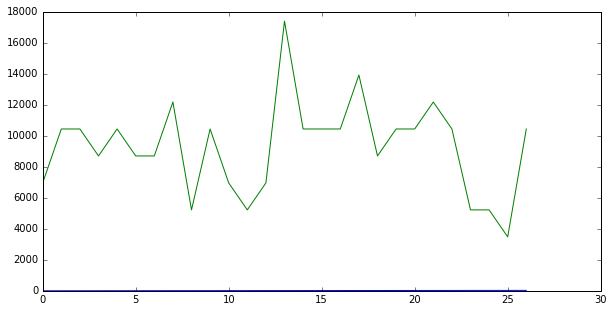

In [15]:
fig = plt.figure(figsize=(10,5))
zone = (rdd.map(lambda x: (x.zona,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(zone)

Aree
---

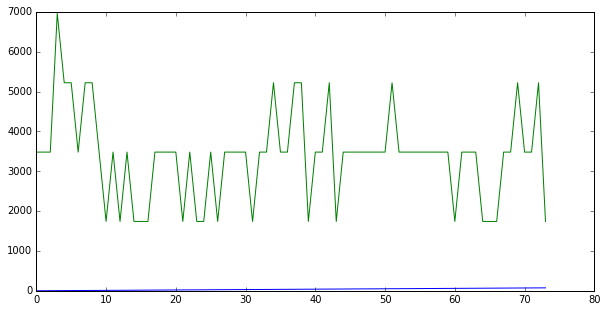

In [16]:
fig = plt.figure(figsize=(10,5))
aree = (rdd.map(lambda x: (x.area,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(aree)

Categorie
---

In [17]:
categorie = (rdd.map(lambda x: (x.categoria,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
categorie

[(1, 125280), (2, 125280)]

Vendite per settimana
---

In [8]:
vendite_settimana_tot = (rdd.filter(lambda x: x.anno != 2016).map(lambda x: (x.settimana_dell_anno,x.vendite))
                       .reduceByKey(lambda x,y: x+y)).collect()
vendite_settimana_2014 = (rdd.filter(lambda x: x.anno == 2014).map(lambda x: (x.settimana_dell_anno,x.vendite))
                       .reduceByKey(lambda x,y: x+y)).collect()
vendite_settimana_2015 = (rdd.filter(lambda x: x.anno == 2015).map(lambda x: (x.settimana_dell_anno,x.vendite))
                       .reduceByKey(lambda x,y: x+y)).collect()
vendite_settimana_2016 = (rdd.filter(lambda x: x.anno == 2016).map(lambda x: (x.settimana_dell_anno,x.vendite))
                       .reduceByKey(lambda x,y: x+y)).collect()

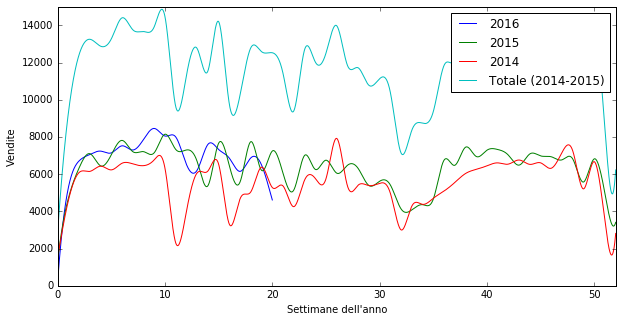

In [50]:

fig = plt.figure(figsize=(10,5))
plt.xlim([0, 52]) 
plt.ylim([0, 15000])
ax = fig.add_subplot(111)
ax.set_xlabel('Settimane dell\'anno')
ax.set_ylabel('Vendite')


def plot_smooth(data,label):
    x = list(map(lambda x: x[0], data))
    y = list(map(lambda x: x[1], data))
    x_new = np.linspace(0,max(x),30000)
    y = spline(x,y,x_new)
    plt.plot(x_new,y, label=label)


plot_smooth(vendite_settimana_2016, label = '2016')
plot_smooth(vendite_settimana_2015, label = '2015')
plot_smooth(vendite_settimana_2014, label = '2014')
plot_smooth(vendite_settimana_tot,'Totale (2014-2015)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

# Integrazione con dati GPS

In [75]:
collected_rdd = rdd.collect()

In [76]:
df = pd.DataFrame.from_records(collected_rdd,columns = row._fields)

In [77]:
locations = pd.read_csv('dataset/output/gps_processed.csv',index_col=0)

In [78]:
# Mergiamo le nuove feature e binarizziamo le regioni e zona

df = df.merge(locations[
        ['sottoarea','regione','zona_italia','isola','abitanti','min_distanza',
         'densita','indice_istruzione','reddito_medio','gini_index',
        'forza_lavoro', 'occupazione']
    ], on='sottoarea')

df = pd.get_dummies(df, columns={'regione'} )
df = pd.get_dummies(df, columns={'zona_italia'} )

In [79]:
list(df.columns.values)

['zona',
 'area',
 'sottoarea',
 'categoria',
 'timestamp',
 'giorno_della_settimana',
 'giorno_del_mese',
 'giorno_dell_anno',
 'settimana_dell_anno',
 'mese',
 'anno',
 'festivo',
 'vendite',
 'isola',
 'abitanti',
 'min_distanza',
 'densita',
 'indice_istruzione',
 'reddito_medio',
 'gini_index',
 'forza_lavoro',
 'occupazione',
 'regione_ABR',
 'regione_BAS',
 'regione_CAL',
 'regione_CAM',
 'regione_EMR',
 'regione_FVG',
 'regione_LAZ',
 'regione_LIG',
 'regione_LOM',
 'regione_MAR',
 'regione_MOL',
 'regione_PIE',
 'regione_PUG',
 'regione_SAR',
 'regione_SIC',
 'regione_TAA',
 'regione_TOS',
 'regione_UMB',
 'regione_VEN',
 'zona_italia_Centro',
 'zona_italia_Nord',
 'zona_italia_Sud']

In [80]:
df.to_csv('dataset/output/dataset_polimi_extended.csv',sep = ',',index = False)

In [81]:
# Aggiungiamo e binarizziamo anche la provincia
df = df.merge(locations[
        ['sottoarea','provincia']
    ], on='sottoarea')

df = pd.get_dummies(df, columns={'provincia'} )

In [82]:
df.to_csv('dataset/output/dataset_polimi_extended_with_province.csv',sep = ',',index = False)